In [1]:
import numpy as np
import torch
import random
import pandas as pd
from PIL import Image


def view_images(images, num_rows=1, offset_ratio=0.02):
    if type(images) is list:
        num_empty = len(images) % num_rows
    elif images.ndim == 4:
        num_empty = images.shape[0] % num_rows
    else:
        images = [images]
        num_empty = 0

    empty_images = np.ones(images[0].shape, dtype=np.uint8) * 255
    images = [image.astype(np.uint8) for image in images] + [empty_images] * num_empty
    num_items = len(images)

    h, w, c = images[0].shape
    offset = int(h * offset_ratio)
    num_cols = num_items // num_rows
    image_ = np.ones((h * num_rows + offset * (num_rows - 1),
                      w * num_cols + offset * (num_cols - 1), 3), dtype=np.uint8) * 255
    for i in range(num_rows):
        for j in range(num_cols):
            image_[i * (h + offset): i * (h + offset) + h:, j * (w + offset): j * (w + offset) + w] = images[
                i * num_cols + j]

    pil_img = Image.fromarray(image_)
    return pil_img


def diffusion_step(model, latents, context, t, guidance_scale, low_resource=False):
    if low_resource:
        noise_pred_uncond = model.unet(latents, t, encoder_hidden_states=context[0])["sample"]
        noise_prediction_text = model.unet(latents, t, encoder_hidden_states=context[1])["sample"]
    else:
        latents_input = torch.cat([latents] * 2)
        noise_pred = model.unet(latents_input, t, encoder_hidden_states=context)["sample"]
        noise_pred_uncond, noise_prediction_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_prediction_text - noise_pred_uncond)
    latents = model.scheduler.step(noise_pred, t, latents)["prev_sample"]
    return latents


def latent2image(vae, latents):
    latents = 1 / 0.18215 * latents
    image = vae.decode(latents)['sample']
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).numpy()
    image = (image * 255).astype(np.uint8)
    return image


def init_latent(latent, model, height, width, generator, batch_size):
    if latent is None:
        latent = torch.randn(
            (1, model.unet.in_channels, height // 8, width // 8),
            generator=generator,
        )
    latents = latent.expand(batch_size,  model.unet.in_channels, height // 8, width // 8).to(model.device)
    return latent, latents


@torch.no_grad()
def text2image_ldm_stable(
    model,
    prompt,
    num_inference_steps = 50,
    guidance_scale = 7.5,
    generator = None,
    latent = None,
    low_resource = False,
):
    height = width = 512
    batch_size = len(prompt)

    text_input = model.tokenizer(
        prompt,
        padding="max_length",
        max_length=model.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    text_embeddings = model.text_encoder(text_input.input_ids.to(model.device))[0]
    max_length = text_input.input_ids.shape[-1]
    uncond_input = model.tokenizer(
        [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    uncond_embeddings = model.text_encoder(uncond_input.input_ids.to(model.device))[0]
    
    context = [uncond_embeddings, text_embeddings]
    if not low_resource:
        context = torch.cat(context)
    latent, latents = init_latent(latent, model, height, width, generator, batch_size)
    
    model.scheduler.set_timesteps(num_inference_steps)
    for t in model.scheduler.timesteps:
        latents = diffusion_step(model, latents, context, t, guidance_scale, low_resource)
    
    image = latent2image(model.vae, latents)

#     image, _ = model.run_safety_checker(image=image, device=model.device, dtype=text_embeddings.dtype)
  
    return image

In [2]:
import torch
import numpy as np
import ast

"""
TRAIN FUNCTION DEFINITION:
    train(model: StableDiffusionPipeline,
          projection_matrices: list[size=L](nn.Module),
          og_matrices: list[size=L](nn.Module),
          contexts: list[size=N](torch.tensor[size=MAX_LEN,...]),
          valuess: list[size=N](list[size=L](torch.tensor[size=MAX_LEN,...])),
          old_texts: list[size=N](str),
          new_texts: list[size=N](str),
          **kwargs)
    where L is the number of matrices to edit, and N is the number of sentences to train on (batch size).
PARAMS:
    model: the model to use.
    projection_matrices: list of projection matrices to edit from the model.
    og_matrices: list of original values for the projection matrices. detached from the model.
    contexts: list of context vectors (inputs to the matrices) to edit.
    valuess: list of results from all matrices for each context vector.
    old_texts: list of sentences to be edited.
    new_texts: list of target sentences to be aimed at.
    **kwargs: additional command line arguments.
TRAIN_FUNC_DICT defined at the bottom of the file.
"""

def baseline_train(model, projection_matrices, og_matrices, contexts, valuess, old_texts, new_texts):
    return None

def train_closed_form(ldm_stable, projection_matrices, og_matrices, contexts, valuess, old_texts,
          new_texts, ret_contexts, ret_valuess, ret_texts,
          ret_new_texts, layers_to_edit=None, lamb=0.1, retain = False):
    layers_to_edit = ast.literal_eval(layers_to_edit) if type(layers_to_edit) == str else layers_to_edit
    lamb = ast.literal_eval(lamb) if type(lamb) == str else lamb

    for layer_num in range(len(projection_matrices)):
        if (layers_to_edit is not None) and (layer_num not in layers_to_edit):
            continue

        with torch.no_grad():
            #mat1 = \lambda W + \sum{v k^T}
            mat1 = lamb * projection_matrices[layer_num].weight

            #mat2 = \lambda I + \sum{k k^T}
            mat2 = lamb * torch.eye(projection_matrices[layer_num].weight.shape[1], device = projection_matrices[layer_num].weight.device)

            #aggregate sums for mat1, mat2
            for context, values in zip(contexts, valuess):
                context_vector = context.reshape(context.shape[0], context.shape[1], 1)
                context_vector_T = context.reshape(context.shape[0], 1, context.shape[1])
                value_vector = values[layer_num].reshape(values[layer_num].shape[0], values[layer_num].shape[1], 1)
                for_mat1 = (value_vector @ context_vector_T).sum(dim=0)
                for_mat2 = (context_vector @ context_vector_T).sum(dim=0)
                mat1 += for_mat1
                mat2 += for_mat2
            if retain:
                #aggregate sums for mat1, mat2
                for context, values in zip(ret_contexts, ret_valuess):
                    context_vector = context.reshape(context.shape[0], context.shape[1], 1)
                    context_vector_T = context.reshape(context.shape[0], 1, context.shape[1])
                    value_vector = values[layer_num].reshape(values[layer_num].shape[0], values[layer_num].shape[1], 1)
                    for_mat1 = (value_vector @ context_vector_T).sum(dim=0)
                    for_mat2 = (context_vector @ context_vector_T).sum(dim=0)
                    mat1 += for_mat1
                    mat2 += for_mat2

            #update projection matrix
            projection_matrices[layer_num].weight = torch.nn.Parameter(mat1 @ torch.inverse(mat2))

TRAIN_FUNC_DICT = {
 "baseline": baseline_train,
 "train_closed_form": train_closed_form,
}

In [17]:
import torch
from diffusers import StableDiffusionPipeline
import numpy as np
import abc
import copy
import os

## get arguments for our script
with_to_k = True
with_augs = True
train_func = "train_closed_form"

### load model
LOW_RESOURCE = True
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
ldm_stable = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device)
tokenizer = ldm_stable.tokenizer

### get layers
ca_layers = []
def append_ca(net_):
    if net_.__class__.__name__ == 'CrossAttention':
        ca_layers.append(net_)
    elif hasattr(net_, 'children'):
        for net__ in net_.children():
            append_ca(net__)

sub_nets = ldm_stable.unet.named_children()
for net in sub_nets:
        if "down" in net[0]:
            append_ca(net[1])
        elif "up" in net[0]:
            append_ca(net[1])
        elif "mid" in net[0]:
            append_ca(net[1])

### get projection matrices
ca_clip_layers = [l for l in ca_layers if l.to_v.in_features == 768]
projection_matrices = [l.to_v for l in ca_clip_layers]
og_matrices = [copy.deepcopy(l.to_v) for l in ca_clip_layers]
if with_to_k:
    projection_matrices = projection_matrices + [l.to_k for l in ca_clip_layers]
    og_matrices = og_matrices + [copy.deepcopy(l.to_k) for l in ca_clip_layers]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


In [18]:
def edit_model(old_text_, new_text_, retain_text_,layers_to_edit=None, lamb=0.1):
    #### restart LDM parameters
    num_ca_clip_layers = len(ca_clip_layers)
    for idx_, l in enumerate(ca_clip_layers):
        l.to_v = copy.deepcopy(og_matrices[idx_])
        projection_matrices[idx_] = l.to_v
        if with_to_k:
            l.to_k = copy.deepcopy(og_matrices[num_ca_clip_layers + idx_])
            projection_matrices[num_ca_clip_layers + idx_] = l.to_k
    layers_to_edit = ast.literal_eval(layers_to_edit) if type(layers_to_edit) == str else layers_to_edit
    lamb = ast.literal_eval(lamb) if type(lamb) == str else lamb

    for layer_num in range(len(projection_matrices)):
        if (layers_to_edit is not None) and (layer_num not in layers_to_edit):
            continue
#     try:
    #### set up sentences
        old_texts = old_text_
        new_texts = []
        for old_text in old_texts:
            new_texts.append(new_text_)

        if retain_text_ is None:
            retain_text__ = ['']
        else:
            retain_text__ = retain_text_
        ret_texts = retain_text__
        ret_new_texts = []
        for ret_text in ret_texts:
            ret_new_texts.append(ret_text)
        retain = False
        if retain_text_ is not None:
            retain = True
        #### prepare input k* and v*
        with torch.no_grad():
            #mat1 = \lambda W + \sum{v k^T}
            mat1 = lamb * projection_matrices[layer_num].weight

            #mat2 = \lambda I + \sum{k k^T}
            mat2 = lamb * torch.eye(projection_matrices[layer_num].weight.shape[1], device = projection_matrices[layer_num].weight.device)

            for old_text, new_text in zip(old_texts, new_texts):
                text_input = ldm_stable.tokenizer(
                    [old_text, new_text],
                    padding="max_length",
                    max_length=ldm_stable.tokenizer.model_max_length,
                    truncation=True,
                    return_tensors="pt",
                )
                text_embeddings = ldm_stable.text_encoder(text_input.input_ids.to(ldm_stable.device))[0]
                old_emb, new_emb = text_embeddings
                context = old_emb.detach()
                values = []
                with torch.no_grad():
                    for layer in projection_matrices:
                        values.append(layer(new_emb[:]).detach())
                context_vector = context.reshape(context.shape[0], context.shape[1], 1)
                context_vector_T = context.reshape(context.shape[0], 1, context.shape[1])
                value_vector = values[layer_num].reshape(values[layer_num].shape[0], values[layer_num].shape[1], 1)
                for_mat1 = (value_vector @ context_vector_T).sum(dim=0)
                for_mat2 = (context_vector @ context_vector_T).sum(dim=0)
                mat1 += for_mat1
                mat2 += for_mat2

            for old_text, new_text in zip(ret_texts, ret_new_texts):
                text_input = ldm_stable.tokenizer(
                    [old_text, new_text],
                    padding="max_length",
                    max_length=ldm_stable.tokenizer.model_max_length,
                    truncation=True,
                    return_tensors="pt",
                )
                text_embeddings = ldm_stable.text_encoder(text_input.input_ids.to(ldm_stable.device))[0]
                old_emb, new_emb = text_embeddings
                context = old_emb.detach()
                values = []
                with torch.no_grad():
                    for layer in projection_matrices:
                        values.append(layer(new_emb[:]).detach())
                context_vector = context.reshape(context.shape[0], context.shape[1], 1)
                context_vector_T = context.reshape(context.shape[0], 1, context.shape[1])
                value_vector = values[layer_num].reshape(values[layer_num].shape[0], values[layer_num].shape[1], 1)
                for_mat1 = (value_vector @ context_vector_T).sum(dim=0)
                for_mat2 = (context_vector @ context_vector_T).sum(dim=0)
                mat1 += for_mat1
                mat2 += for_mat2
                #update projection matrix
            projection_matrices[layer_num].weight = torch.nn.Parameter(mat1 @ torch.inverse(mat2))  
#     #### define training function
#     train = TRAIN_FUNC_DICT[train_func]
    
    
#     #### train the model
#     train(ldm_stable, projection_matrices, og_matrices, contexts, valuess, old_texts,
#           new_texts, ret_contexts, ret_valuess, ret_texts,
#           ret_new_texts, lamb=lamb, retain = retain)

    return f'Current model status: Edited "{str(old_text_)}" into "{str(new_text_)}" and Retained "{str(retain_text_)}"'

def generate_for_text(test_text, seed = 1231):
    g = torch.Generator(device='cpu')
    g.manual_seed(seed)
    images = text2image_ldm_stable(ldm_stable, [test_text], latent=None, num_inference_steps=NUM_DIFFUSION_STEPS, guidance_scale=GUIDANCE_SCALE, generator=g, low_resource=LOW_RESOURCE)
    return view_images(images)

# Testing the limit of the algorithm

In [23]:
import pandas as pd
df = pd.read_csv('data/artists1734_prompts.csv')
artists = list(df.artist.unique())
print(len(artists))

erasure_counts = [1, 5, 10, 25, 50, 100, 500, 1000, 1500, 1734]
for count in erasure_counts:
    
    erasure_idxs = np.arange(len(artists))
    random.shuffle(erasure_idxs)
    erasure_idxs = erasure_idxs[:count]
    
    erase_artists = []
    preserve_artists = [] 
    for i, artist in enumerate(artists):
        if i in erasure_idxs:
            erase_artists.append(artist)
        else:
            preserve_artists.append(artist)
    print(f'Erasing {count} artists')
    with open(f'data/erase{count}.txt', 'w') as fp:
        for item in erase_artists:
            fp.write(item+'\n')
    
    
    ldm_stable = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device)
    tokenizer = ldm_stable.tokenizer

    ### get layers
    ca_layers = []
    def append_ca(net_):
        if net_.__class__.__name__ == 'CrossAttention':
            ca_layers.append(net_)
        elif hasattr(net_, 'children'):
            for net__ in net_.children():
                append_ca(net__)

    sub_nets = ldm_stable.unet.named_children()
    for net in sub_nets:
            if "down" in net[0]:
                append_ca(net[1])
            elif "up" in net[0]:
                append_ca(net[1])
            elif "mid" in net[0]:
                append_ca(net[1])

    ### get projection matrices
    ca_clip_layers = [l for l in ca_layers if l.to_v.in_features == 768]
    projection_matrices = [l.to_v for l in ca_clip_layers]
    og_matrices = [copy.deepcopy(l.to_v) for l in ca_clip_layers]
    if with_to_k:
        projection_matrices = projection_matrices + [l.to_k for l in ca_clip_layers]
        og_matrices = og_matrices + [copy.deepcopy(l.to_k) for l in ca_clip_layers]
        
    ######### EDIT THE MODEL
    edit_model(old_text_=erase_artists, new_text_='', retain_text_= preserve_artists, lamb=0.5)
    torch.save(ldm_stable.unet.state_dict(), f'models/diffusers-erasing-{count}-with-preservation.pt')

1734
['Salomon van Ruysdael']
Erasing 1 artists


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.
/share/u/rohit/.conda/envs/pytorch/lib/python3.9/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


Parameter containing:
tensor([[-0.0165,  0.0055,  0.0022,  ...,  0.0146,  0.0020,  0.0124],
        [-0.0442,  0.0172,  0.0142,  ...,  0.0058,  0.0025, -0.0136],
        [-0.0042, -0.0005, -0.0137,  ..., -0.0211, -0.0180, -0.0218],
        ...,
        [ 0.0052, -0.0156, -0.0064,  ..., -0.0151, -0.0150,  0.0366],
        [ 0.0132, -0.0417,  0.0220,  ...,  0.0026,  0.0183, -0.0220],
        [ 0.0095, -0.0234, -0.0019,  ...,  0.0143,  0.0135, -0.0164]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 4.5075e-03, -9.9531e-04, -5.9251e-03,  ..., -3.9518e-05,
         -2.3498e-04, -8.1283e-03],
        [-4.4524e-03, -1.1100e-02, -2.0311e-02,  ...,  9.3803e-03,
          1.7852e-03,  2.3984e-02],
        [-5.4880e-03, -1.2753e-02, -1.0583e-02,  ...,  4.4048e-05,
          5.9663e-03,  4.8181e-03],
        ...,
        [-9.7258e-04, -2.4932e-02,  1.8688e-02,  ...,  4.2551e-03,
          6.3723e-03, -5.5458e-03],
        [ 1.4094e-02, -8.8860e-03,  2.3593e-02,  ...,

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_681242/3253705936.py:58 in <module>                                               │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_681242/3253705936.py'                       │
│                                                                                                  │
│ /tmp/ipykernel_681242/1911221290.py:73 in edit_model                                             │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_681242/1911221290.py'                       │
│                                                                                                  │
│ /share/u/rohit/.conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/module.py:1130   │
│ in _call_impl                                                                                    │
│                                                                                                  │
│   1127 │   │   # this function, and just call forward.                                           │
│   1128 │   │   if not (self._backward_hooks or self._forward_hooks or self._forward_pre_hooks o  │
│   1129 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1130 │   │   │   return forward_call(*input, **kwargs)                                         │
│   1131 │   │   # Do not call functions when jit is used                                          │
│   1132 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1133 │   │   if self._backward_hooks or _global_backward_hooks:                                │
│                                                                                                  │
│ /share/u/rohit/.conda/envs/pytorch/lib/python3.9/site-packages/transformers/models/clip/modeling │
│ _clip.py:816 in forward                                                                          │
│                                                                                                  │
│    813 │   │   ```"""                                                                            │
│    814 │   │   return_dict = return_dict if return_dict is not None else self.config.use_return  │
│    815 │   │                                                                                     │
│ ❱  816 │   │   return self.text_model(                                                           │
│    817 │   │   │   input_ids=input_ids,                                                          │
│    818 │   │   │   attention_mask=attention_mask,                                                │
│    819 │   │   │   position_ids=position_ids,                                                    │
│                                                                                                  │
│ /share/u/rohit/.conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/module.py:1130   │
│ in _call_impl                                                                                    │
│                                                                                                  │
│   1127 │   │   # this function, and just call forward.                                           │
│   1128 │   │   if not (self._backward_hooks or self._forward_hooks or self._forward_pre_hooks o  │
│   1129 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1130 │   │   │   return forward_call(*input, **kwargs)                                         │
│   1131 │   │   # Do not call functions when jit is used                                          │
│   1132 │   │   full_backward_hooks, non_full_backward_hooks

# Testing Original Models

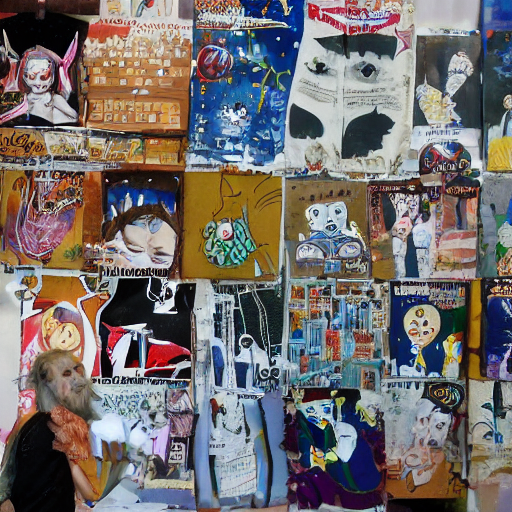

In [21]:
generate_for_text('Kelly McKernan Painting', seed = 123)

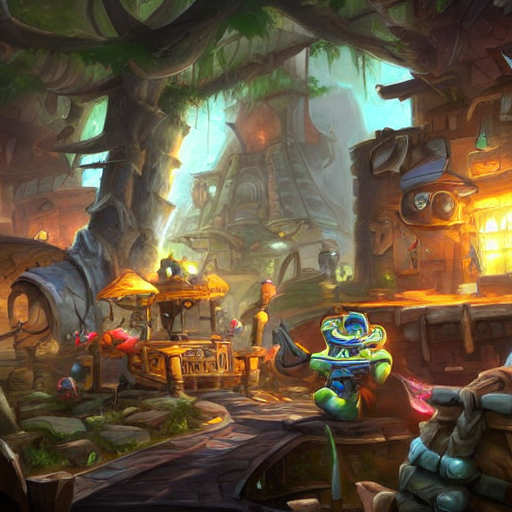

In [22]:
generate_for_text('Tyler Edlin Painting', seed = 45236523)

In [ ]:
generate_for_text('Kilian Eng Painting', seed = 2342345)

In [ ]:
generate_for_text('Thomas Kinkade Painting', seed = 31546641)

In [ ]:
generate_for_text('Ajin: Demi Human Painting', seed = 42434)

In [ ]:
generate_for_text('Caravaggio Painting', seed = 12425)

In [ ]:
generate_for_text('Picasso Painting', seed = 1231)

In [ ]:
generate_for_text('Monet Painting', seed = 3141)

In [ ]:
generate_for_text('Van Gogh Painting', seed = 3141)

In [ ]:
generate_for_text('Rembrandt Painting', seed = 123123)

# Erasing artist styles - No Retention

In [ ]:
edit_model(old_text_=['Kelly McKernan', 'Thomas Kinkade', 'Kilian Eng', 'Tyler Edlin', 'Ajin: Demi Human'], new_text_='art', retain_text_= None, lamb=0.5)

In [ ]:
torch.save(ldm_stable.unet.state_dict(), 'models/diffusers-erasing-niche-with-None-preserved.pt')

# Testing Edited Models

In [ ]:
generate_for_text('Kelly McKernan Painting', seed = 123)

In [ ]:
generate_for_text('Tyler Edlin Painting', seed = 45236523)

In [ ]:
generate_for_text('Kilian Eng Painting', seed = 2342345)

In [ ]:
generate_for_text('Thomas Kinkade Painting', seed = 31546641)

In [ ]:
generate_for_text('Ajin: Demi Human Painting', seed = 42434)

In [ ]:
generate_for_text('Caravaggio Painting', seed = 12425)

In [ ]:
generate_for_text('Picasso Painting', seed = 1231)

In [ ]:
generate_for_text('Monet Painting', seed = 3141)

In [ ]:
generate_for_text('Van Gogh Painting', seed = 3141)

In [ ]:
generate_for_text('Rembrandt Painting', seed = 123123)

# Erasing artist styles - With Retention

In [ ]:
## get arguments for our script
with_to_k = True
with_augs = True
train_func = "train_closed_form"

### load model
LOW_RESOURCE = True
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')


In [ ]:
edit_model(old_text_=['Kelly McKernan', 'Thomas Kinkade', 'Kilian Eng', 'Tyler Edlin', 'Ajin: Demi Human'], new_text_='art', retain_text_= ['Van Gogh', 'Picasso', 'Rembrandt', 'Monet', 'Caravaggio'], lamb=0.5)

In [ ]:
torch.save(ldm_stable.unet.state_dict(), 'models/diffusers-erasing-niche-with-famous-preserved.pt')

# Testing Edited Models

In [ ]:
generate_for_text('Kelly McKernan Painting', seed = 123)

In [ ]:
generate_for_text('Tyler Edlin Painting', seed = 45236523)

In [ ]:
generate_for_text('Kilian Eng Painting', seed = 2342345)

In [ ]:
generate_for_text('Thomas Kinkade Painting', seed = 31546641)

In [ ]:
generate_for_text('Ajin: Demi Human Painting', seed = 42434)

In [ ]:
generate_for_text('Caravaggio Painting', seed = 12425)

In [ ]:
generate_for_text('Picasso Painting', seed = 1231)

In [ ]:
generate_for_text('Monet Painting', seed = 3141)

In [ ]:
generate_for_text('Van Gogh Painting', seed = 3141)

In [ ]:
generate_for_text('Rembrandt Painting', seed = 123123)

In [ ]:
artists = ['Kelly McKernan', 'Kilian Eng', 'Thomas Kinkade', 'Tyler Edlin', 'Ajin: Demi Human']
for i, artist in enumerate(artists):
    erase_artist = [artist]
    preserve_artists = artists[:i]+artists[i+1:]
    
    ldm_stable = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device)
    tokenizer = ldm_stable.tokenizer

    ### get layers
    ca_layers = []
    def append_ca(net_):
        if net_.__class__.__name__ == 'CrossAttention':
            ca_layers.append(net_)
        elif hasattr(net_, 'children'):
            for net__ in net_.children():
                append_ca(net__)

    sub_nets = ldm_stable.unet.named_children()
    for net in sub_nets:
            if "down" in net[0]:
                append_ca(net[1])
            elif "up" in net[0]:
                append_ca(net[1])
            elif "mid" in net[0]:
                append_ca(net[1])

    ### get projection matrices
    ca_clip_layers = [l for l in ca_layers if l.to_v.in_features == 768]
    projection_matrices = [l.to_v for l in ca_clip_layers]
    og_matrices = [copy.deepcopy(l.to_v) for l in ca_clip_layers]
    if with_to_k:
        projection_matrices = projection_matrices + [l.to_k for l in ca_clip_layers]
        og_matrices = og_matrices + [copy.deepcopy(l.to_k) for l in ca_clip_layers]
        
        
    
    edit_model(old_text_=erase_artist, new_text_='', retain_text_= preserve_artists, lamb=0.5)
    torch.save(ldm_stable.unet.state_dict(), f'models/diffusers-erasing-{artist.replace(" ","")}-with-preservation.pt')
    

In [ ]:
artists = ['Kelly McKernan', 'Kilian Eng', 'Thomas Kinkade', 'Tyler Edlin', 'Ajin: Demi Human']
for i, artist in enumerate(artists):
    erase_artist = [artist]
    preserve_artists = artists[:i]+artists[i+1:]
    
    ldm_stable = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device)
    tokenizer = ldm_stable.tokenizer

    ### get layers
    ca_layers = []
    def append_ca(net_):
        if net_.__class__.__name__ == 'CrossAttention':
            ca_layers.append(net_)
        elif hasattr(net_, 'children'):
            for net__ in net_.children():
                append_ca(net__)

    sub_nets = ldm_stable.unet.named_children()
    for net in sub_nets:
            if "down" in net[0]:
                append_ca(net[1])
            elif "up" in net[0]:
                append_ca(net[1])
            elif "mid" in net[0]:
                append_ca(net[1])

    ### get projection matrices
    ca_clip_layers = [l for l in ca_layers if l.to_v.in_features == 768]
    projection_matrices = [l.to_v for l in ca_clip_layers]
    og_matrices = [copy.deepcopy(l.to_v) for l in ca_clip_layers]
    if with_to_k:
        projection_matrices = projection_matrices + [l.to_k for l in ca_clip_layers]
        og_matrices = og_matrices + [copy.deepcopy(l.to_k) for l in ca_clip_layers]
        
        
    
    edit_model(old_text_=erase_artist, new_text_='', retain_text_= None, lamb=0.5)
    torch.save(ldm_stable.unet.state_dict(), f'models/diffusers-erasing-{artist.replace(" ","")}-without-preservation.pt')
    